In [1]:
import numpy as np
import pyemma
import matplotlib
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import math
import h5py
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')
%load_ext cython

In [2]:
%%cython
import numpy as np
cimport numpy as np
from multiprocessing import Pool
cdef extern from "math.h":
    double atan2(double y, double x)
    
cdef double PI = np.pi

cdef class trajDiscretizationCython:
    cdef object centers
    cdef public double innerMSMrad, bathRadOut, radialIncrementEntry, radialIncrementExit, radialIncrementBath
    cdef public int angularPartitions, entryRings, exitRings, bathRings, radialPartitions, Ncenters, Nstates, bathIndex
    def __init__(self, np.ndarray[double, ndim=2] centers):
        self.centers = centers
        self.innerMSMrad = 2.0
        self.angularPartitions = 48
        self.Ncenters = len(self.centers)
        self.Nstates = self.Ncenters + self.angularPartitions + 1
        
    cpdef np.int32_t getAngularState(self, np.ndarray[double, ndim=1] coord):
        cdef np.float64_t theta = atan2(coord[1], coord[0]) + PI
        cdef np.int32_t angularState = int(theta*self.angularPartitions/(2*PI))
        return angularState
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    
    cdef np.int32_t getState(self, np.ndarray[np.float64_t, ndim=1] coord, np.int32_t prevst):
        cdef np.float64_t radius = np.linalg.norm(coord)
        cdef np.ndarray[np.float64_t, ndim=2] cen2coord
        cdef np.ndarray[np.float64_t, ndim=1] norm
        cdef np.int32_t index
        # inner MSM
        if radius < self.innerMSMrad:
            for index in range(self.Ncenters):
                if (self.centers[index][0] - coord[0])**2 + (self.centers[index][1] - coord[1])**2 < 0.04:
                    return index
            return prevst
        else:
        #    return prevst
            angularState = self.getAngularState(coord)
            return self.Ncenters + angularState
        
    # Compute the discrete trajectory from a trajectory
    # given as np array

    cpdef getdTraj(self, np.ndarray[np.float64_t, ndim=2] traj):
        cdef np.int32_t k, checker, i 
        cdef np.ndarray[np.int32_t, ndim=1] dTraj
        # Skip first elements, that might have udefined behavior.
        k = 0
        checker = self.getState(traj[0], -1)
        while checker < 0 and k < len(traj)-2:
            k += 1
            checker = self.getState(traj[k], -1)
        dTraj = np.empty(len(traj)-k, dtype=np.int32)
        dTraj[0] = checker
        # Get state for the remainder of the trajectory
        for i in range(1, len(traj)-k):
            dTraj[i] = self.getState(traj[i+k], dTraj[i-1])
        return dTraj
    
    # Compute a list of discrete trajectories from a list of continuous trajectories
    # This function calls the getdTraj for each element in the list
    
    cpdef getdTrajs(self, list trajs):
        cdef np.ndarray[np.float64_t, ndim=2] traj
        cdef np.ndarray[np.int32_t, ndim=1] dTraj, validIndices
        cdef list dTrajs = []
        cdef int k, checker,i 
        for traj in trajs:
            dTrajs.append(self.getdTraj(traj))
            '''
            dTraj = self.getdTraj(traj)
            validIndices = np.where(dTraj != -1)[0].astype(np.int32)
            if validIndices.size > 0:
                dTrajs.append(dTraj[validIndices])
                '''
        return dTrajs
    
    # Truncate trajectories at the radius give by self.innerMSMrad
    # The first and last data points outside of the ring will be added to the trajectory 
    
    cpdef getTruncatedTraj(self, np.ndarray[double, ndim=2] traj):
        cdef list currentTraj
        cdef list innerTrajs = []
        cdef bint trajActive = False
        cdef bint innerTrajActive = False
        cdef np.ndarray[double, ndim=1] norm
        cdef int length
        norm = np.linalg.norm(traj, axis = 1)
        trajActive = False
        innerTrajActive = False
        length = len(traj)
        #Loop over trajectory
        for i in range(0, length):
            if not trajActive:
                if norm[i]<self.innerMSMrad:
                    #Start a new truncated trajectory. Maybe add previous state!
                    trajActive = True
                    if i > 0:
                        currentTraj = [traj[i]] #[traj[i-1], traj[i]]
                    else:
                        currentTraj = [traj[i]]
            else:
                # There is already and active trajectory!
                if norm[i] > self.innerMSMrad:
                    # Trajectory exits domain. Finish it by appending the last data point
                    # and adding it to the list of trajectories
                    trajActive = False
                    currentTraj.append(traj[i]) 
                    innerTrajs.append(np.array(currentTraj)) 
                else:
                    # Data point is inside domain. Add it to the active trajectory
                    currentTraj.append(traj[i])
        return innerTrajs
        
    
    cpdef getTruncatedTrajs(self, list trajs):
        cdef list innerTrajs = []
        for traj in trajs:
            innerTrajs = innerTrajs + self.getTruncatedTraj(traj)
        return innerTrajs
    
    # This function truncates the trajectories in the passed list when they enter a new state
    # It returns a nested list of the format transitionTrajs[from state i][to state j][trajectory index]
    
    cpdef getTransitionTrajs(self, list dTruncTrajs):
        cdef np.ndarray[np.int32_t, ndim=1] dTruncTraj
        cdef list transitionTrajs = []
        cdef list fromi = []
        cdef list toj = []
        #created nested list to store transition trajectories
        for k in range(self.Ncenters+1):
            fromi = []
            for l in range(self.Ncenters+1):
                toj = []
                fromi.append(toj)
            transitionTrajs.append(fromi)
        cdef int i, initialState
        for dTruncTraj in dTruncTrajs:
            if np.any(dTruncTraj< 0):
                #invalid trajectories are skipped
                continue
            initialState = dTruncTraj[0]
            initialIndex = 0
            #loop over trajectory
            for i in range(1, len(dTruncTraj)):
                #this indicates a transition. Trajectory leading to this transition is extracted and added to list.
                if dTruncTraj[i] != initialState:
                    finalState = min(dTruncTraj[i], self.Ncenters)
                    initialState = min(initialState, self.Ncenters)
                    transitionTrajs[initialState][finalState].append(initialState * np.ones(i-initialIndex, dtype=int))
                    initialState = dTruncTraj[i]
                    initialIndex = i
        return transitionTrajs
    
    # This function generates a lookup table for trajectories which are entering the domain from the bath.
    # It returns the starting coordinates, first state the respective trajectory hits as well as its length
    
    cpdef getLookupTableEntry(self, list dTrajs, list truncTrajs):
        cdef np.ndarray[long, ndim=1] dTraj
        cdef np.ndarray[double, ndim=1] entryCoord
        cdef int j, i, currentState, entryState
        cdef list entryCoords = []
        cdef list firstStates = []
        cdef list times = []
        for i in range(len(truncTrajs)):
            if np.any(dTrajs[i] < 0):
                continue
            if np.linalg.norm(truncTrajs[i][0]) < self.innerMSMrad:
                continue
            entryCoords.append(truncTrajs[i][1])
            entryState = dTrajs[i][0]
            j = 0
            currentState = entryState
            while currentState == entryState and j < len(dTrajs[i])-2:
                j += 1
                currentState = dTrajs[i][j]
            times.append(j)
            if currentState >= self.Ncenters:
                firstStates.append(truncTrajs[i][-1])
            else:
                firstStates.append(currentState)
        return np.array(entryCoords), firstStates, np.array(times)
    
    cpdef getLookupTableExit(self, list dTruncTrajs, list truncTrajs):
        cdef int exitFrom, k, state, lastState
        cdef np.ndarray[double, ndim=1] exitPosition
        cdef list exitPositions = []
        cdef list exitTimes = []
        for i in range(self.Nstates):
            exitFromi = []
            timeFromi = []
            exitPositions.append(exitFromi)
            exitTimes.append(timeFromi)
        for i in range(len(dTruncTrajs)):
            if np.any(dTruncTrajs[i] < self.Ncenters):
                if dTruncTrajs[i][-1] > self.Ncenters and len(dTruncTrajs[i]) > 2:
                    lastState = dTruncTrajs[i][-2]
                    exitPositions[lastState].append(truncTrajs[i][-1])
                    exitTime = 0
                    state = lastState
                    while state == lastState:
                        exitTime += 1
                        state = dTruncTrajs[i][(-2-exitTime)]
                    exitTimes[lastState].append(exitTime)
        return exitPositions, exitTimes 
    
    cpdef joinInnerTrajectories(self, transitionTrajs):
        cdef np.ndarray[long, ndim=2] trajCount = np.zeros((self.Ncenters, self.Ncenters), dtype=int)
        cdef int i,j
        cdef np.ndarray[double, ndim=1] nextStepProbs
        cdef int totalTrajs
        cdef int nextState, trajNo, state
        cdef list localTransitionTrajs = []
        cdef list fromi = []
        cdef list toj = []
        for k in range(self.Ncenters):
            fromi = []
            for l in range(self.Ncenters):
                toj = []
                fromi.append(toj)
            localTransitionTrajs.append(fromi)
        for i in range(self.Ncenters):
            for j in range(self.Ncenters):
                trajCount[i,j] = len(transitionTrajs[i][j])
                for k in range(trajCount[i,j]):
                    localTransitionTrajs[i][j].append(np.copy(transitionTrajs[i][j][k]))
        cdef list joinedTrajectory = []
        cdef list joinedTrajs = []
        while np.sum(trajCount) >= 100:
            state = np.argmax(np.sum(trajCount, axis=1))
            joinedTrajectory = []
            totalTrajs = np.sum(trajCount)
            while np.sum(trajCount[state,:]) != 0:
                nextStepProbs = np.copy(trajCount[state,:]).astype(float)
                nextStepProbs /= np.sum(nextStepProbs)
                nextState = np.random.choice(self.Ncenters, p=nextStepProbs)
                trajNo = np.random.choice(len(localTransitionTrajs[state][nextState]))
                joinedTrajectory.append(localTransitionTrajs[state][nextState][trajNo])
                localTransitionTrajs[state][nextState].pop(trajNo)
                trajCount[state, nextState] -= 1
                state = nextState
            if len(joinedTrajectory) >= 2:
                joinedTrajs.append(np.concatenate(joinedTrajectory))
        return joinedTrajs
    
    def removeExternalTrajs(self, dTruncTrajs):
        Ncenters = 9
        cTrajs = []
        for traj in dTruncTrajs:
            innerIdcs = np.where(traj<Ncenters)[0]
            if len(innerIdcs != 0):
                innerTraj = traj[innerIdcs]
                if np.any(innerTraj != innerTraj[0]):
                    cTrajs.append(innerTraj)
        return cTrajs

In [3]:
def getLookupTableExit(dTruncTrajs, truncTrajs):
    exitPositions = []
    exitTimes = []
    Ncenters = 9
    for i in range(Ncenters):
        exitFromi = []
        timeFromi = []
        exitPositions.append(exitFromi)
        exitTimes.append(timeFromi)
    for i in range(len(dTruncTrajs)):
        if np.any(dTruncTrajs[i] < Ncenters):
            if dTruncTrajs[i][-1] >= Ncenters and len(dTruncTrajs[i]) > 2:
                lastState = dTruncTrajs[i][-2]
                exitPositions[lastState].append(truncTrajs[i][-1])
                exitTime = 0
                state = lastState
                while state == lastState and exitTime < len(dTruncTrajs[i])-2:
                    exitTime += 1
                    state = dTruncTrajs[i][(-2-exitTime)]
                exitTimes[lastState].append(exitTime)
    return exitPositions, exitTimes 

In [4]:
%%time
numfiles = 1
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/2DasymTrajsLong_R4_RT1E7_dt001_SI1_'
dimension = 2
minima = np.array([[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]])
discretizer = trajDiscretizationCython(minima)
trajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], 1):
        print 'timestep not constant'
    traj = data[::1,1:dimension+1]
    lastTruncTrajs = discretizer.getTruncatedTraj(traj)
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj

CPU times: user 43.7 s, sys: 213 ms, total: 43.9 s
Wall time: 43.9 s


In [ ]:
print np.linalg.norm(truncTrajs[0],axis=1)

In [5]:
%%cython
import numpy as np
cimport numpy as np

cdef class trajReconstructor:
    cdef public double innerRadius, outerRadius, timeStep, diff, sigma
    cdef public int dim
    def __init__(self, double innerRadius, double outerRadius, double timeStep, double diff, int dim):
        self.innerRadius = innerRadius
        self.outerRadius = outerRadius
        self.timeStep = timeStep
        self.diff = diff
        self.sigma = np.sqrt(2*self.timeStep*self.diff)
        self.dim = dim

      
    cpdef reconstructTraj(self, np.ndarray[np.float64_t, ndim=1] initialPosition):
        cdef np.ndarray[np.float64_t, ndim=1] position = initialPosition
        cdef list outerTraj = [position]
        cdef int inBDRegion = 1 
        cdef double rad
        while (inBDRegion == 1):
            position = self.integrate(position)
            rad = np.linalg.norm(position)
            outerTraj.append(position)
            if (rad <= self.innerRadius):
                inBDRegion = 0
                return outerTraj
            elif (rad >= self.outerRadius):
                inBdRegion = 0
                return outerTraj
            else:
                continue    
        
    cdef integrate(self, np.ndarray[np.float64_t, ndim=1] position):
        cdef np.ndarray[np.float64_t, ndim=1] dr = np.random.normal(0., self.sigma, self.dim)
        return position + dr
        

In [6]:
trajReconstruct = trajReconstructor(2.0,4,0.001,1.0,2)

In [7]:
# Initialize trajectory reconstruction
reconstructedTrajs = truncTrajs[0]
# Write first entry of truncTrajs into trajEntry
trajEntry = []
for traj in truncTrajs:
    trajEntry.append(traj[0])

In [16]:
# Loop to glue trajectories
for i in range(10):
    lastPosition = reconstructedTrajs[-1]
    outerTraj = np.array(trajReconstruct.reconstructTraj(lastPosition))
    # Dont use first point in outerTraj since it is already in reconstructedTraj
    reconstructedTrajs = np.concatenate((reconstructedTrajs, outerTraj[1:]), axis=0)
    # Find next trajIndex
    entryPoint = reconstructedTrajs[-1]
    entryNorm = np.linalg.norm(entryPoint)
    if entryNorm < 4:
        norms = np.linalg.norm(trajEntry - entryPoint, axis=1)
        trajIndex = np.argmin(norms)
        # Dont use last point of reconstructedTrajs since it is substituted by first one of truncTrajs
        reconstructedTrajs = np.concatenate((reconstructedTrajs[:-1], truncTrajs[trajIndex]), axis=0)
    else:
        print "Broken traj"
        break

Broken traj


3333


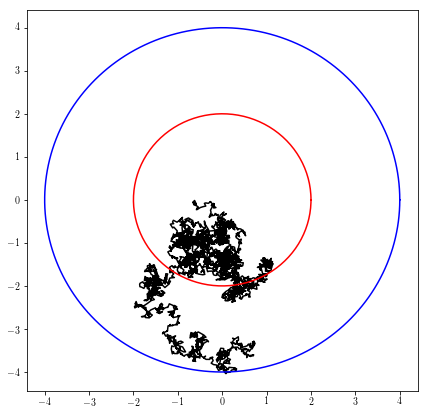

In [17]:
xx = []
yy = []
th = np.linspace(0,2*np.pi,200)
x=2*np.cos(th)
y=2*np.sin(th)
x2=4*np.cos(th)
y2=4*np.sin(th)
for pt in reconstructedTrajs:
    xx.append(pt[0])
    yy.append(pt[1])
print(len(reconstructedTrajs))
plt.plot(xx,yy,'-k')
plt.plot(x,y,'-r')
plt.plot(x2,y2,'-b')

In [ ]:
th = np.linspace(0,2*np.pi,200)
th

In [ ]:
truncTrajs[1][0]

In [ ]:
outerTraj

In [ ]:
for i in range(len(outerTraj)):
    print np.linalg.norm(outerTraj[i])